Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


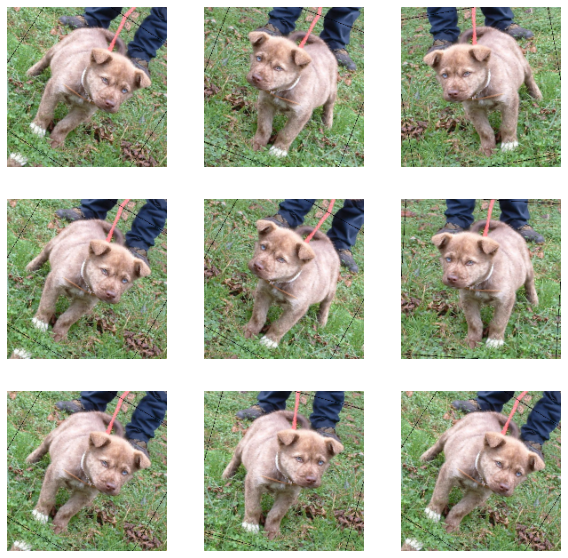

In [36]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt 
from tensorflow.keras.utils import plot_model
import pydot
num_skipped = 0
for folder_name in ("Cat","Dog"):
    folder_path = os.path.join("PetImages",folder_name)
    #print(folder_path)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path,fname)
        try:
            fobj = open(fpath,"rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()
        if not is_jfif:
            num_skipped +=1
            os.remove(fpath)

image_size = (180,180)
batch_size = 32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split = 0.2,
    subset = "training",
    seed = 1337,
    image_size = image_size,
    batch_size = 32

)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split = 0.2,
    subset = "validation",
    seed = 1337,
    image_size = image_size,
    batch_size = 32

)
data_augmentation = keras.Sequential(
[
  layers.experimental.preprocessing.RandomFlip('horizontal'),
  layers.experimental.preprocessing.RandomRotation(0.1),
    
])
plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        augmented_images = data_augmentation(images)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        #plt.title(int(labels[i]))
        plt.axis("off")
augmented_train_ds = train_ds.map(
lambda x,y:(data_augmentation(x,training=True),y))

train_ds  = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

def make_model(input_shape,num_classes):
    inputs = keras.Input(shape=input_shape)
    
    x = data_augmentation(inputs)
    x = layers.experimental.preprocessing.Rescaling(1.0/255)(x)
    x = layers.Conv2D(32,33,strides=2,padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    previous_block_activation = x
    
    for size in [128,256,512,728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size,3,padding='same')(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.MaxPooling2D(3,strides=2,padding='same')(x)
        
        residual = layers.Conv2D(size,1,strides=2,padding='same')(previous_block_activation)
    x = layers.SeparableConv2D(1024,3,padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)




In [37]:
model = make_model(input_shape=image_size + (3,), num_classes=2)
epochs = 2

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/2
586/586 [==============================] - 2279s 4s/step - loss: 0.6180 - accuracy: 0.6630 - val_loss: 0.5648 - val_accuracy: 0.7053
Epoch 2/2
586/586 [==============================] - 2221s 4s/step - loss: 0.5054 - accuracy: 0.7540 - val_loss: 0.7926 - val_accuracy: 0.6010


In [38]:
converter = tf.lite.TFLiteConverter.from_keras_model(model) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpxf0q08r_/assets


In [39]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

This image is 97.48 percent cat and 2.52 percent dog.
